In [64]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [156]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 20", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc


def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc


def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

# for fname in ['scf.hdf5','ci.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_h2(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

converged SCF energy = -0.955690248895949  <S^2> = 2  2S+1 = 3


In [157]:
# Jastrow optimization
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, verbose=False)

In [158]:
# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

,energy,iteration,error,fname
0,-0.997716,0,0.002301,sj.hdf5
1,-0.999744,1,0.000701,sj.hdf5


In [167]:
#ABDMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['dmc2.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC


# ABVMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", verbose=False, nsteps = 5000, branchtime = 5, tstep= 0.02, nconfig=500)
ABDMC("scf.hdf5", "dmc2.hdf5",  load_parameters="sj.hdf5", accumulators = {"energy": True}, verbose=False, 
      nsteps = 2000, branchtime = 10, tstep= 0.01, nconfig=100, vmc_warmup=10)

(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100, 2, 3)
(100

KeyboardInterrupt: 

In [160]:
f = h5py.File("dmc2.hdf5")
print(f.keys())
# f['energyke']

<KeysViewHDF5 ['Number of walkers killed', 'acceptance', 'configs', 'e_est', 'e_trial', 'energycorr', 'energyee', 'energyei', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'esigma', 'max branches', 'nsteps', 'step', 'tmove_acceptance', 'tstep', 'weight', 'weight_std', 'weights']>


Mean  etot_abdmc ,  -1.0018225916417356 +/- 0.0002196863534721259
Mean  ee_abdmc ,  0.050164954495251116 +/- 1.1703279798530258e-07
Mean  vh_abdmc ,  1.3103009755774848 +/- 0.00048706374029622144
Mean  vxc_abdmc ,  -0.7402237539029746 +/- 0.00038643156176944386
Mean  ecorr_abdmc ,  -0.5278456734326142 +/- 1.1339875512552045e-32
Mean  ei_abdmc ,  -2.026415140236602 +/- 0.009341770648599746
Mean  ii_abdmc ,  0.04999999999999999 +/- 2.3367949991898462e-34
Mean  ke_abdmc ,  -0.004064651029862299 +/- 0.00018996668204577835
LDA Energy,  -0.9556902488959487


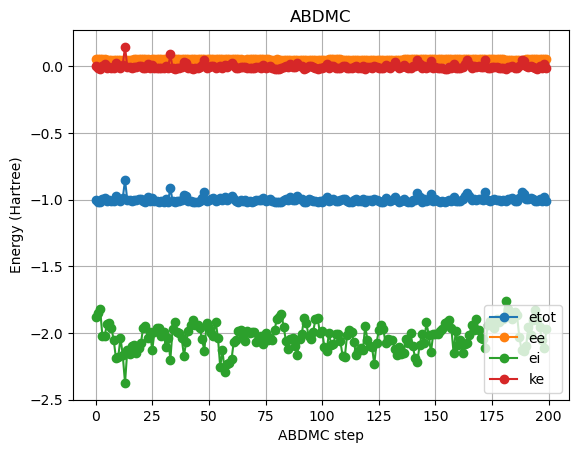

In [161]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("dmc2.hdf5") as f:
    ee_abdmc = f['energyee'][...]   
    ei_abdmc = f['energyei'][...]
    vh_abdmc = f['energyvh'][...]   
    vxc_abdmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abdmc = f['energyii'][...]    
    ke_abdmc = f['energyke'][...]
    ka_abdmc = f['energyka'][...]
    kb_abdmc = f['energykb'][...]   
    ecorr_abdmc = f['energycorr'][...]    
    etot_abdmc = f['energytotal'][...] 
vhxc_abdmc = vxc_abdmc + vh_abdmc
plt.plot(etot_abdmc, marker='o', label="etot")
# plt.plot(ii_abdmc, marker='o', label="ii")
plt.plot(ee_abdmc, marker='o', label="ee")
plt.plot(ei_abdmc, marker='o', label="ei")
plt.plot(ke_abdmc, marker='o', label="ke")
# plt.plot(ka_abdmc, marker='o', label="ka")
# plt.plot(kb_abdmc, marker='o', label="kb")
# plt.plot(vhxc_abdmc, marker='o', label="vhxc")
# plt.plot(ke_abdmc, marker='o', label="ke")

plt.legend()
plt.xlabel("ABDMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABDMC')
discard = 50
for e in [etot_abdmc, ee_abdmc, vh_abdmc, vxc_abdmc, ecorr_abdmc, ei_abdmc, ii_abdmc, ke_abdmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



In [162]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

DMC("scf.hdf5", "dmc.hdf5",  load_parameters="sj.hdf5", 
    accumulators = {"energy": True}, verbose=False, 
    nsteps = 2000, branchtime = 10, tstep= 0.01, nconfig=100, vmc_warmup=100)

In [163]:
f = h5py.File("dmc.hdf5")
print(f.keys())
# f['energyke']

<KeysViewHDF5 ['Number of walkers killed', 'acceptance', 'configs', 'e_est', 'e_trial', 'energyecp', 'energyee', 'energyei', 'energygrad2', 'energyke', 'energytotal', 'esigma', 'max branches', 'nsteps', 'step', 'tmove_acceptance', 'tstep', 'weight', 'weight_std', 'weights']>


Mean  etot_dmc ,  -0.9987939477797156 +/- 3.4056987324887395e-05
Mean  ee_dmc ,  0.05039918915346663 +/- 5.1258909978046203e-08
Mean  ei_dmc ,  -2.026496348168601 +/- 0.011405992315516904
Mean  ke_dmc ,  0.9273032112354187 +/- 0.012194302730482325
LDA Energy,  -0.9556902488959487


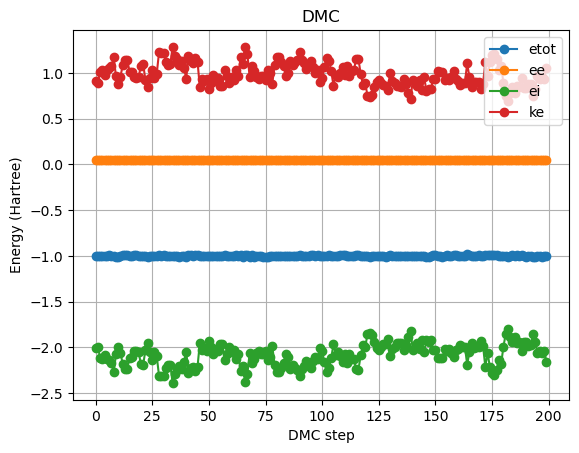

In [164]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("dmc.hdf5") as f:
    etot_dmc = f['energytotal'][...]   
    ee_dmc = f['energyee'][...]   
    ei_dmc = f['energyei'][...]
    ke_dmc = f['energyke'][...]
plt.plot(etot_dmc, marker='o', label="etot")
plt.plot(ee_dmc, marker='o', label="ee")
plt.plot(ei_dmc, marker='o', label="ei")
plt.plot(ke_dmc, marker='o', label="ke")

plt.legend()
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('DMC')
discard = 100
for e in [etot_dmc, ee_dmc, ei_dmc,ke_dmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



3.3986065972990054e-05 0.000369445471668494


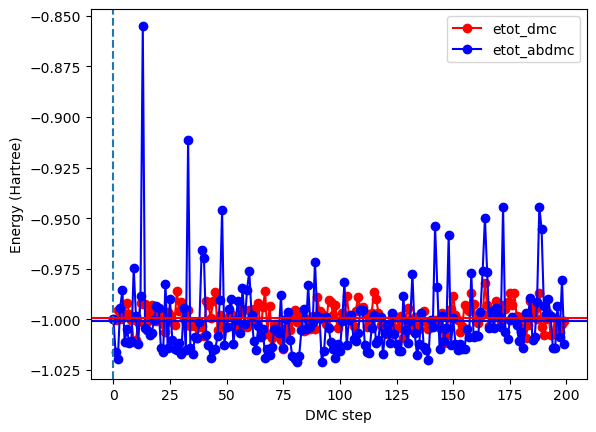

In [165]:
#Compare ABDMC and DMC
plt.plot(etot_dmc, marker='o', color='r', label="etot_dmc")
plt.plot(etot_abdmc, marker='o', color='b', label="etot_abdmc")
plt.legend()
plt.xlabel("DMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

discard = 0
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot_dmc[discard:]), color='r')
plt.axhline(np.mean(etot_abdmc[discard:]), color='b')
plt.grid()
print(np.var(etot_dmc[discard:]),np.var(etot_abdmc[discard:]))


In [110]:
#PYQMC VMC 
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
VMC("scf.hdf5", "vmc.hdf5",  load_parameters="sj.hdf5", verbose=True, nsteps =1000, tstep= 0.01, nconfig=200)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

LDA Energy,  -1.1173655050466031
Mean  etot_vmc ,  -1.1499238577867748 +/- 0.0002533898747790532
Mean  ee_vmc ,  0.6395591118424708 +/- 0.0012407719823042283
Mean  ei_vmc ,  -3.8388695230193752 +/- 0.017714112625827505
Mean  ke_vmc ,  1.2160532200567964 +/- 0.015420248987805751


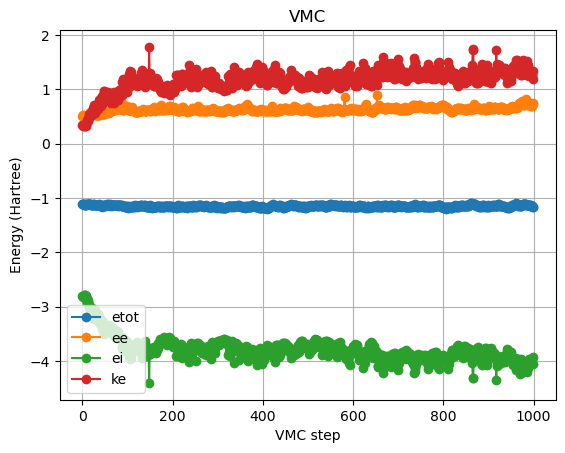

In [116]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("vmc.hdf5") as f:
    etot_vmc = f['energytotal'][...]   
    ee_vmc = f['energyee'][...]   
    ei_vmc = f['energyei'][...]
    ke_vmc = f['energyke'][...]
plt.plot(etot_vmc, marker='o', label="etot")
plt.plot(ee_vmc, marker='o', label="ee")
plt.plot(ei_vmc, marker='o', label="ei")
plt.plot(ke_vmc, marker='o', label="ke")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('VMC')
discard = 100
print("LDA Energy, ", mf_lda.energy_tot())
for e in [etot_vmc, ee_vmc, ei_vmc,ke_vmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
